# Chroma + RAG
- Load PDF, Split into chuncks, Embed, then store in a retrieval system (Chroma)
- Embed Query
- Retrieval system finds most relevant documents (Nearest Neighbour of Query and pdf txt embeddings)
- Return Query and relevant results to LLM
- LLM synthesizes that data

***
## Install packages

In [1]:
%pip install -qqq langchain==0.1.0
%pip install -qqq sentence-transformers==2.2.2
%pip install -qqq openai==1.7.1 umap-learn==0.5.5 #umap==0.1.1

# to avoid RuntimeError: Your system has an unsupported version of sqlite3. Chroma requires sqlite3 >= 3.35.0., install version 0.3.29
%pip install -qqq chromadb==0.3.29 #0.4.22

%pip install -qqq pypdf==3.17.4
%pip install -qqq git+https://github.com/tkra90/magic.git

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from tinymagic.nlp import helpers as nlp_helper

In [3]:
from tqdm.notebook import tqdm
from pypdf import PdfReader
from langchain.text_splitter import (
    RecursiveCharacterTextSplitter, 
    SentenceTransformersTokenTextSplitter
)

***
## Read pdf document

In [4]:
pdf_file = './LLMs/SI-HoMan-PL-en-53.pdf'

# extract text and strip whitespace, remove ..s
pdf_readr = PdfReader(pdf_file)
pdfs = [page.extract_text().strip().replace('..','') for page in tqdm(pdf_readr.pages)]

# filter empty pages
filtered_pdf = [pg for pg in pdfs if pg]

len(pdfs), len(filtered_pdf)

  0%|          | 0/64 [00:00<?, ?it/s]

(64, 63)

In [5]:
print(filtered_pdf[0])

Planning Guidelines
SMA SMART HOME
The System Solution for Greater Independence
SI-HoMan-PL-en-53 | Version 5.3 ENGLISH


In [6]:
print(nlp_helper.wrap_text(filtered_pdf[0], 50, '\n\n'))

Planning Guidelines
SMA SMART HOME
The System

Solution for Greater
Independence
SI-HoMan-PL-en-53 | Version 5.3
ENGLISH


***
## Split text by Characters 

In [7]:
# split by \\n, if still >1000, split by \n etc
char_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", ". ",  " ", ""],
    chunk_size=1000,
    chunk_overlap=0
)

merged_pages = '\n\n'.join(filtered_pdf)
split_text = char_splitter.split_text(merged_pages)

print(f'Nr. of chunks: {len(split_text)}')

Nr. of chunks: 149


In [8]:
print(nlp_helper.wrap_text(split_text[0])[:250])

Planning Guidelines
SMA SMART HOME
The System
Solution for Greater
Independence
SI-HoMan-PL-en-53 | Version 5.3
ENGLISH


***
## Split Tokens
- prepare text for the embedding model

In [9]:
token_splitter = SentenceTransformersTokenTextSplitter(
    chunk_overlap=0, 
    tokens_per_chunk=256
)
# bc embedding model context window  is 256

In [10]:
split_txt_by_token = []
for text in split_text:
    split_txt_by_token += token_splitter.split_text(text)
    
len(split_txt_by_token)

153

In [11]:
print(nlp_helper.wrap_text(split_txt_by_token[0]))

planning guidelines sma smart home the system
solution for greater independence si - homan - pl
- en - 53 | version 5. 3 english


In [12]:
split_txt_by_token[0]

'planning guidelines sma smart home the system solution for greater independence si - homan - pl - en - 53 | version 5. 3 english'

In [13]:
split_txt_by_token[1]

'table of contents sma solar technology ag planning guidelines si - homan - pl - en - 53 2table of contents 1information on this document. 4 1. 1 content and structure of this document. 4 1. 2 symbols in the document 4 1. 3 designations in the document. 5 2pv energy for internal power supply and self - consumption 6 2. 1 why are self - consumption and internal power supply interesting? 6 2. 2 what are the effects of internal power supply and self - consumption? 6 2. 3 what are the requirements for high energy self - sufficiency and self - consumption quotas?. 6 2. 4 increased self - consumption through intelligent energy management. 7 3internal power supply and self - consumption with sma smart home 9 3. 1 basic solution for intelligent energy management. 9 3. 2 storage solutions for new and existing pv systems. 10 4functions for energy management systems. 17 4. 1 load control 17 4. 1. 1 energy monitoring - measuring and understanding energy flows. 17'

***
## Sentence Transformer 
- <a href="https://arxiv.org/pdf/1908.10084.pdf">paper</a>
- state-of-the-art sentence, text and image embeddings, can compute sentence / text embeddings for more than 100 languages
- is based on BERT transformer architecture
- embeds each token individually, pools output of each token embedding to produce a single dense vector per sentence\chunk
- embeddings can then be compared e.g. with cosine-similarity to find sentences with a similar meaning
- useful for semantic textual similar, semantic search, or paraphrase mining

In [14]:
import chromadb
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

In [15]:
embedding_fun = SentenceTransformerEmbeddingFunction(model_name = 'all-MiniLM-L6-v2')

embedded_chunk = embedding_fun([split_txt_by_token[0]])
len(embedded_chunk[0])

384

In [16]:
embedded_chunk[0][:15]

[-0.008290236815810204,
 0.04230229929089546,
 0.03675457835197449,
 -0.04941593483090401,
 0.06758478283882141,
 0.03065255470573902,
 -0.013549256138503551,
 0.009989805519580841,
 -0.12992864847183228,
 0.027583245187997818,
 0.02715235762298107,
 0.009702799841761589,
 0.0440477691590786,
 -0.05999058485031128,
 0.09309713542461395]

In [17]:
# add docs to Chroma
chroma_client = chromadb.Client()
chroma_collection = chroma_client.create_collection(
    "sma_smart_home", 
    embedding_function=embedding_fun
)

indices = [str(i) for i, _ in enumerate(split_txt_by_token)]

chroma_collection.add(ids=indices, documents=split_txt_by_token)
chroma_collection.count()

153

In [18]:
query = "What kind of EV chargers does the system support from SMA?" # evc7, evc22
# query = "Is it possible to connect a hybrid inverter and an EV charger to the Home Manager?"
# query = "What are the supported batteries by the SMA HOME?"
# query = "Does the system support connecting heat pumps?"

results = chroma_collection.query(query_texts=[query], n_results=5)
resulting_docs = results['documents'][0]

for doc in resulting_docs:
    print(nlp_helper.wrap_text(doc))
    print('\n')

• a desk lamp with an energy requirement of e. g.
20 wh can only consume a very small portion of
the pv energy. • toasters and kettles are only
switched on when they are required. toast and hot
water are required promptly. • an electric cooker
is switched on when the user wishes to cook. the
food is to be prepared promptly and not simply
whenever sufficient pv energy is available for
operation of the electric cooker. 5. 2 sma ev
charger in the energy management system the ev
charger is an ac charging station that is
designed for unidirectional charging of a
vehicle. the sma ev charger along with the sunny
home manager 2. 0 makes an intelligent charging
station for the sma energy system home. if the ev
charger is operated without the sunny home
manager 2. 0, the modes for intelligent charging
are not available.


6 kwp = total po wer −1 kwline conductor neutr al
conductor figure 19 : the sma ev charger uses the
single - phase pv generation for faster charging
of the electric vehicle ( b

In [20]:
import openai
from openai import OpenAI

openai_client = OpenAI(api_key=key1)

In [22]:
def run_rag(query, resulting_documents, model = "gpt-3.5-turbo"):
    info = "\n".join(resulting_documents)
    msg = [
        {"role": "system",
         "content":"You are a helpful solar systems engineer. Your client asks you questions about a certain product from a catalogue. "
         "You will be shown client's question, and the relevant info. Answer using only the relevant info that is given to you."
        },
        {"role": "user", 
         "content": f"Question: {query}, \n  Relevant info: {info}"
        }
    ]
    
    response = openai_client.chat.completions.create(messages=msg, model=model)
    return response.choices[0].message.content

res = run_rag(query, resulting_docs)

In [23]:
print(nlp_helper.wrap_text(res))

The system supports SMA EV chargers. The SMA EV
charger is an AC charging station designed for
unidirectional charging of a vehicle. It is
compatible with the Sunny Home Manager 2.0 to
make an intelligent charging station for the SMA
energy system home. The modes for intelligent
charging are only available when the EV charger
is operated with the Sunny Home Manager 2.0. In
multi-EVC operation mode, up to 3 SMA EV chargers
can be connected, and both single-phase and
three-phase charging stations are possible. The
Sunny Home Manager provides information on the
number of active charging stations every minute.


*** 
## Dim. Reduction + Visu of Embeddings
- project high dim data to 2D to visualize
- Uniform Manifold Approximation <a href='https://umap.scikit-tda.org/basic_usage.html'>Basic Usage </a>
- similar to TSNe, PCA

In [21]:
import umap
import numpy as np
import matplotlib.pyplot as plt

In [22]:
embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
# umap.UMAP
umap_transformer = umap.UMAP(n_components=2,
                             random_state=42,
                             transform_seed=42,
                             n_jobs=1).fit(embeddings)

In [23]:
def get_2d_projections(emb, umap_transform):
    umap_embeddings = np.empty((len(emb),2))
    print(umap_embeddings.shape)
    for i, embdi in enumerate(tqdm(emb)):
        umap_embeddings[i] = umap_transform.transform([embdi])
    return umap_embeddings

In [24]:
projected_embeddings = get_2d_projections(embeddings, umap_transformer)

(153, 2)


  0%|          | 0/153 [00:00<?, ?it/s]

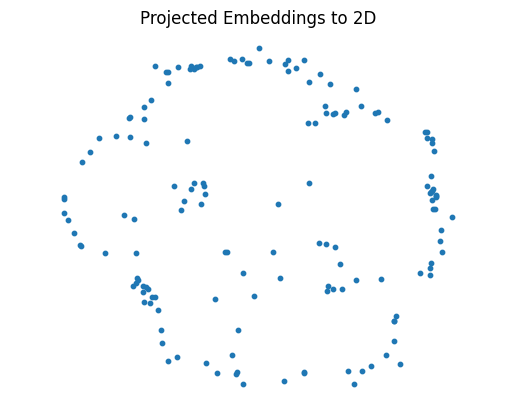

In [25]:
plt.figure()
plt.scatter(projected_embeddings[:, 0], projected_embeddings[:, 1], s=10)
plt.gca().set_aspect('equal', 'datalim')
plt.title('Projected Embeddings to 2D')
plt.axis('off');

In [26]:
from typing import List, Union

def query_chroma_collection(query: str, chroma_col: chromadb.api.Collection, n: int = 5)-> dict:
    """
    Query the ChromaDB, a helper function.
    Parameters:
    - query (str): The input text to query the DB.
    - chroma_col (chromadb.api.Collection): The ChromaDB collection.
    - n (int): number of results to generate (default = 5)

    Returns:
    - dict: A dictionary with the results (documents and embeddings).
    """
    res = chroma_col.query(query_texts=query, 
                           n_results=n,
                           include=['documents', 'embeddings'])
    return res


def wrap_results(doc: Union[List [str], str]) -> str:
    """
    Wrap results of a ChromaDB colection query.
    Parameters:
    - doc (Union[List [str], str]): The input can be list of string or a string.

    Returns:
    - str: A wrapped result of the query
    """
    if isinstance(doc, list):
        res = ''
        for d in doc:
            res += nlp_helper.wrap_text(d) + '\n\n'
        return res            
    else:
        return nlp_helper.wrap_text(doc)

In [27]:
query1 = "Is it possible to connect heat pumps to the system?"

results = query_chroma_collection(query1, chroma_collection, 7)

In [28]:
print(wrap_results(results['documents'][0]))

in principle there are two types of control
interfaces for this : • sma radio - controlled
sockets • direct data connection • moxa for sg -
ready heat pumps and power control functionality

( terminal 9 and 10 ). these switching contacts
then start the heat pump in a special operating
mode in which surplus pv energy can be used to
operate the heat pump. direct data connection
some modern home appliances ( see technical
information " sma smart home - compatibility list
for loads " at www. sma - solar. com ) have an
ethernet connection with which the data of the
device can be called up via the local network. if
there is an internet connection via the network
router, the manufacturers of household devices
can use this data for maintenance purposes, for
example. visualization and control of the
household devices via mobile devices ( e. g. via
app in the smartphone ) is also possible with
this. a further application of this direct data
connection is the control of the device via the
sunny h

In [29]:
query_embedding = embedding_fun([query1])[0]
resulting_embeddings = results['embeddings'][0]

projected_q_emb = get_2d_projections([query_embedding], umap_transformer)
projected_resulting_emb = get_2d_projections(resulting_embeddings, umap_transformer)

(1, 2)


  0%|          | 0/1 [00:00<?, ?it/s]

(7, 2)


  0%|          | 0/7 [00:00<?, ?it/s]

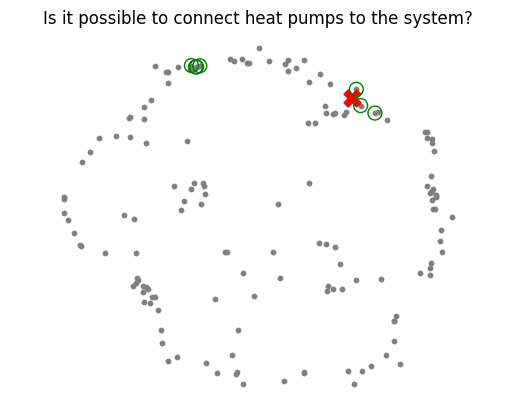

In [30]:
# Plot query and retrieved documents

plt.figure()
plt.scatter(projected_embeddings[:, 0], projected_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_q_emb[:, 0], projected_q_emb[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_resulting_emb[:, 0], projected_resulting_emb[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query1}', fontsize=12)
plt.axis('off');

In [31]:
query2 = "Is it possible to connect a hybrid inverter and an EV charger to the Home Manager?"

results = query_chroma_collection(query2, chroma_collection, 7)

In [32]:
print(wrap_results(results['documents'][0]))

available to achieve the charging goal, the
optionally available home storage is first
discharged for charging the electric vehicle
before the grid - supplied power finally ensures
the readiness for de - parture. after sufficient
charging for the target range, the ev charger
automatically switches to charging with pv
surplus. multi - evc operation mode multi - evc
operation is supported from firmware version 1.
02. # #. r and allows the connection of a maximum
of 3 sma ev chargers. mixed systems with single -
phase charging stations ( evc7. 4 - 1ac - 10 )
and three - phase charging stations ( evc22 - 3ac
- 10 ) are possible. in multi - evc operation
mode, all charging stations must be connected to
the utility grid on a rolling basis. the sunny
home manager provides the charging stations with
information on the number of active charging
stations every minute. in multi - evc operation
mode, if multiple charging stations are charging
a vehicle and there is a two - phase charging

ration o

In [33]:
query_embedding = embedding_fun([query2])[0]
resulting_embeddings = results['embeddings'][0]

projected_q_emb = get_2d_projections([query_embedding], umap_transformer)
projected_resulting_emb = get_2d_projections(resulting_embeddings, umap_transformer)

(1, 2)


  0%|          | 0/1 [00:00<?, ?it/s]

(7, 2)


  0%|          | 0/7 [00:00<?, ?it/s]

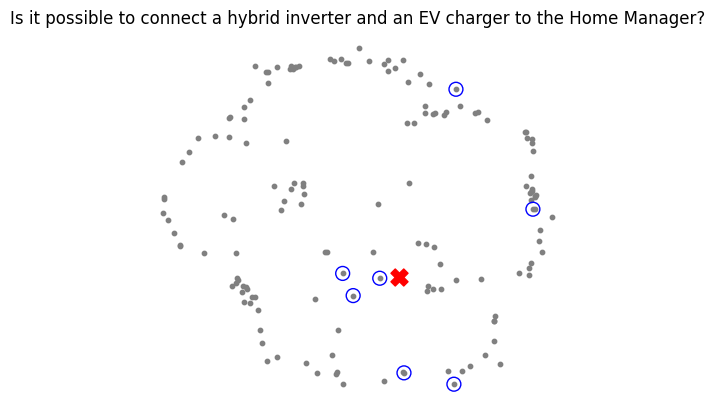

In [34]:
# Plot query and retrieved documents

plt.figure()
plt.scatter(projected_embeddings[:, 0], projected_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_q_emb[:, 0], projected_q_emb[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_resulting_emb[:, 0], projected_resulting_emb[:, 1], s=100, facecolors='none', edgecolors='b')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query2}', fontsize=12)
plt.axis('off');

(1, 2)


  0%|          | 0/1 [00:00<?, ?it/s]

(5, 2)


  0%|          | 0/5 [00:00<?, ?it/s]

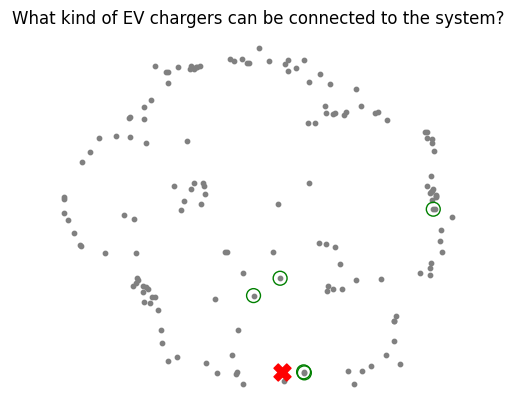

In [35]:
query3 = "What kind of EV chargers can be connected to the system?" 
results = query_chroma_collection(query3, chroma_collection, 5)

query_embedding = embedding_fun([query3])[0]
resulting_embeddings = results['embeddings'][0]

projected_q_emb = get_2d_projections([query_embedding], umap_transformer)
projected_resulting_emb = get_2d_projections(resulting_embeddings, umap_transformer)

# Plot query and retrieved documents
plt.figure()
plt.scatter(projected_embeddings[:, 0], projected_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_q_emb[:, 0], projected_q_emb[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_resulting_emb[:, 0], projected_resulting_emb[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query3}', fontsize=12)
plt.axis('off');

In [ ]:
# improve qualities of the queries!

In [35]:
# try and compare with PCA! 